In [2]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
# import pandas as pd
import xarray as xr
from scipy import signal

In [3]:
# fileLocation = '/Users/tennismichel/Coding/Python/DLR_LIDAR/Data'
fileLocation = '../../v8combined'
fileName = "20190610-2015_T20Z900.nc"
#fileName = "20180106-0206_T20Z900.nc"

path = os.path.join(fileLocation, fileName)

In [4]:
DS = xr.open_dataset(path, decode_times=False)
# attrs = {'units': 'seconds since 2019-10-15 00:00:00'}
# ds = xr.Dataset({'time': ('time', DS.time, attrs)})
DS.time.values = DS.time.values / 1000
DS.integration_start_time.values = DS.integration_start_time.values / 1000
DS.integration_end_time.values = DS.integration_end_time.values / 1000

# Decode the time offset
unit_str = DS.time_offset.attrs['units']
unit_str = unit_str[14:-6]

time_reference = datetime.datetime.strptime(unit_str, '%Y-%m-%d %H:%M:%S.%f')
time_offset = datetime.timedelta(seconds=float(DS.time_offset.values[0]))
new_time_reference = time_reference + time_offset
time_reference_str = datetime.datetime.strftime(new_time_reference, '%Y-%m-%d %H:%M:%S')

DS.time.attrs['units'] = 'seconds since ' + time_reference_str
DS.integration_start_time.attrs['units'] = 'seconds since ' + time_reference_str
DS.integration_end_time.attrs['units'] = 'seconds since ' + time_reference_str

DS = xr.decode_cf(DS, decode_coords = True, decode_times = True) 

# date for plotting should always refer to the center of the plot (04:00 UTC)
start_date = datetime.datetime.utcfromtimestamp(DS.time.values[0].astype('O')/1e9)
ten_pm_date = datetime.datetime(start_date.year, start_date.month, start_date.day, 22, 0,0)
if start_date.hour > 22:
    DS['date_startp'] = ten_pm_date
    DS['date_endp'] = ten_pm_date + datetime.timedelta(hours=12)
else:
    DS['date_startp'] = ten_pm_date - datetime.timedelta(hours=24)
    DS['date_endp'] = ten_pm_date - datetime.timedelta(hours=12)

## Altitude ## 
DS['alt_plot'] = DS.altitude/1000 + DS.altitude_offset + DS.station_height #km

## Temperature ## 
# Change 0 to NaN
DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature)
# date = datetime.datetime.strptime(DS.date_data_start, '%b %d %H:%M:%S %Y')

In [5]:
DS

<xarray.Dataset>
Dimensions:                 (altitude: 1600, channels: 1, time: 110, value: 1)
Coordinates:
  * time                    (time) datetime64[ns] 2019-06-10T20:46:55 ... 2019-06-11T05:51:55
  * altitude                (altitude) uint32 0 100 200 ... 159700 159800 159900
Dimensions without coordinates: channels, value
Data variables:
    station_latitude        (value) float64 ...
    station_longitude       (value) float64 ...
    station_height          (value) uint32 ...
    time_offset             (value) datetime64[ns] ...
    altitude_offset         (value) uint32 ...
    wavelength              (channels) float64 ...
    zenith_cosine           (time) float64 ...
    z0                      (time) uint32 ...
    integration_start_time  (time) datetime64[ns] ...
    integration_end_time    (time) datetime64[ns] ...
    max_countrate           (time) uint32 ...
    countrate_limit_bin     (time) uint32 ...
    temperature             (time, altitude) float32 nan nan nan ... nan nan nan
    temperature_err         (time, altitude) float32 ...
    date_startp             datetime64[ns] 2019-06-09T22:00:00
    date_endp               datetime64[ns] 2019-06-10T10:00:00
    alt_plot                (altitude, value) float64 0.0 0.1 ... 159.8 159.9
Attributes:
    title:             Lidar temperature profiles
    summary:           This file contains temperature profiles retrieved from...
    comment:           
    institution:       German Aerospace Center (DLR), Institute of Atmospheri...
    creator_name:      Bernd Kaifler
    creator_url:       http://www.dlr.de/pa
    creator_email:     bernd.kaifler@dlr.de
    cmdline:           ./CFConvert -db southwave2.cfdb -c -u -split 60000 -o ...
    version:           VERSION
    date_created:      Jun 12 20:28:16 2019
    campaign_name:     
    station_name:      
    instrument_name:   
    history:           Jun 12 20:28:16 2019, file created with MELISA 1424.
    date_data_start:   Jun 10 20:46:55 2019
    snr_limit:         4.0
    background_limit:  10000.0
    signal_limit:      10000.0
    sim_runs:          200

In [14]:
# Time reference 
# Code this with unit string
# referenceYear = 1970
#t0 = datetime.datetime(referenceYear, 1, 1)
#t_start = t0 + datetime.timedelta(seconds=float(DS.variables['time_offset'][0]))

# DS.time.astype('datetime64[ms]')[0] + np.datetime64(t_start, 'ns')
# d = DS.temperature.resample(time='6H')


### Timestamp ###
# ts2 = (DS.integration_end_time - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
# ts1 = (DS.integration_start_time - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
# np.datetime64(datetime.datetime.utcfromtimestamp(ts_centered[1]))

In [15]:
# Time coordinates
# DS.assign_coords(time = np.datetime64(DS.time) + np.datetime64(t_start))

# dt = (DS.integration_end_time + DS.integration_start_time) / 2
# DS.assign_coords(timeCentered = dt.astype('datetime64[ms]') + np.datetime64(t_start))
DS = DS.assign_coords(timeCentered = ((DS.integration_end_time - DS.integration_start_time) / 2 + DS.integration_start_time))
# print('Time{}  {:2.2%}'.format(yes_votes, percentage)
# print(DS)

<xarray.Dataset>
Dimensions:                 (altitude: 1600, channels: 1, time: 185, value: 1)
Coordinates:
  * time                    (time) datetime64[ns] 2019-06-12T21:00:45 ... 2019-06-13T12:20:45
  * altitude                (altitude) uint32 0 100 200 ... 159700 159800 159900
    timeCentered            (time) datetime64[ns] 2019-06-12T21:00:45 ... 2019-06-13T12:20:45
Dimensions without coordinates: channels, value
Data variables:
    station_latitude        (value) float64 ...
    station_longitude       (value) float64 ...
    station_height          (value) uint32 ...
    time_offset             (value) datetime64[ns] ...
    altitude_offset         (value) uint32 ...
    wavelength              (channels) float64 ...
    zenith_cosine           (time) float64 ...
    z0                      (time) uint32 ...
    integration_start_time  (time) datetime64[ns] ...
    integration_end_time    (time) datetime64[ns] ...
    max_countrate           (time) uint32 ...
    countrate_l

/Users/tennismichel/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


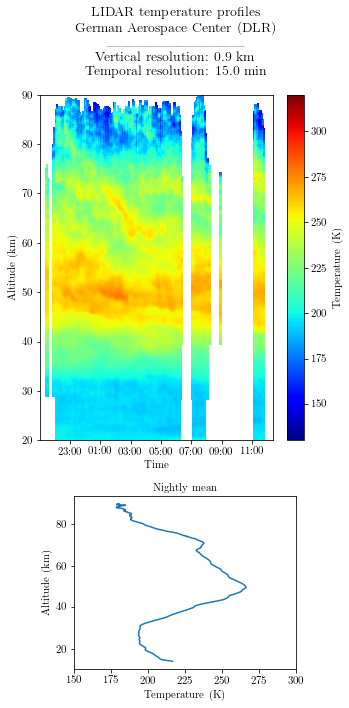

In [12]:
### PLOT ###
# seaborn.set()

use_tex = 1 
if use_tex:
    ### Set tex font
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    # Set font size
    SMALL_SIZE = 10.95
    MEDIUM_SIZE = 10.95
    plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    ###

# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# plt.rcParams['font.family'] = "sans-serif"
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5,10), gridspec_kw={'height_ratios': [2, 1]})
# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
im_temp = ax0.pcolormesh(DS.time, DS.alt_plot, np.matrix.transpose(DS.temperature.values),
                         cmap='jet', vmin=130, vmax=320)
ax0.set_ylim(20,90)

# Labels
cbar = fig.colorbar(im_temp, ax=ax0)
cbar.set_label('Temperature (K)')
ax0.set_xlabel('Time')
ax0.set_ylabel('Altitude (km)')

# X-Ticks
# if day > daybefore show date in new line
h_fmt = mdates.DateFormatter('%H:%M')
h_interv = mdates.HourLocator(interval = 2)
ax0.xaxis.set_major_locator(h_interv)
ax0.xaxis.set_major_formatter(h_fmt)
#ax0.set_xlim(DS.date_startp.values,DS.date_endp.values)

# tempMean = np.where(tempMean == 0, np.nan, tempMean)

## Mean Plot (altitude vs. temperature)
ax1.plot(DS.temperature.mean(axis=0), DS.alt_plot)
ax1.set_xlim(150,300)
ax1.set_aspect('1.4')

# Labels 
ax1.set_title('Nightly mean')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (km)')

fig.suptitle('LIDAR temperature profiles\n \
German Aerospace Center (DLR) \n \
------------------------------ \n \
Vertical resolution: {} km\n \
Temporal resolution: {} min'.format(DS.altitude.resolution / 1000, DS.time.resolution / (1000*60)), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.88]) # tuple (left, bottom, right, top),
# annotate() for fixed ratios

<xarray.DataArray (time: 102, altitude: 1600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 2019-10-15T00:22:55 ... 2019-10-15T08:47:55
  * altitude      (altitude) uint32 0 100 200 300 ... 159700 159800 159900
    timeCentered  (time) datetime64[ns] 2019-10-15T00:21:40 ... 2019-10-15T08:47:55


TypeError: descriptor 'strftime' requires a 'datetime.date' object but received a 'numpy.datetime64'

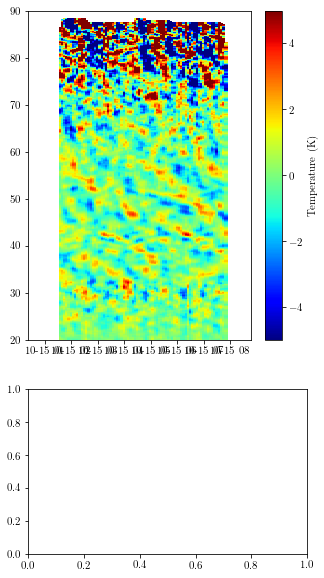

In [74]:
#### Running mean ####
tmp_mean = DS.temperature.rolling(time=20, center = True).mean(dim='time')
DS.info
print(tmp_mean)
DS['tmp_variations'] = DS.temperature-tmp_mean
DS

use_tex = 1 
if use_tex:
    ### Set tex font
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    # Set font size
    SMALL_SIZE = 10.95
    MEDIUM_SIZE = 10.95
    plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    ###

# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# plt.rcParams['font.family'] = "sans-serif"
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5,10), gridspec_kw={'height_ratios': [2, 1]})
# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
im_temp = ax0.pcolormesh(DS.time, DS.alt_plot, np.matrix.transpose(DS.tmp_variations.values),
                         cmap='jet', vmin= -5, vmax = 5)
ax0.set_ylim(20,90)

# Labels
cbar = fig.colorbar(im_temp, ax=ax0)
cbar.set_label('Temperature (K)')
ax0.set_xlabel('Time ({})'.format(datetime.datetime.strftime(DS.date_endp.values, '%b %d, %Y')))
ax0.set_ylabel('Altitude (km)')

# X-Ticks
# if day > daybefore show date in new line
h_fmt = mdates.DateFormatter('%H:%M')
h_interv = mdates.HourLocator(interval = 2)
ax0.xaxis.set_major_locator(h_interv)
ax0.xaxis.set_major_formatter(h_fmt)

#fig.autofmt_xdate()
#xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
#ax0.xaxis.set_major_formatter(xfmt)


# tempMean = np.where(tempMean == 0, np.nan, tempMean)

## Mean Plot (altitude vs. temperature)
ax1.plot(DS.temperature.mean(axis=0), DS.alt_plot)
ax1.set_xlim(150,300)
ax1.set_aspect('1.4')

# Labels 
ax1.set_title('Nightly mean')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (km)')

fig.suptitle('LIDAR temperature profiles\n \
German Aerospace Center (DLR) \n \
------------------------------ \n \
Vertical resolution: {} km\n \
Temporal resolution: {} min'.format(DS.altitude.resolution / 1000, DS.time.resolution / (1000*60)), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.88]) # tuple (left, bottom, right, top),
# annotate() for fixed ratios

In [64]:
def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high_crit = highcut / nyq
    # high_crit = 0.1
    print(high_crit)
    b, a = signal.butter(order, high_crit, btype='lowpass', analog=False)
    return b, a

## Example
n = 5  # the larger n is, the smoother curve will be
b = [1.0 / n] * n # Vector of size n filled with 1/n
a = 1
#a = [1] + [0.8]*4

highcut = 1/20 # 20km critical wavelength
fs = 1/0.1 # 100m sample wavelength
b, a = butter_lowpass(highcut, fs, order=5)

print(b,a)

c = np.append(np.flip(DS.temperature.values, axis=1), DS.temperature.values, axis=1)
y_ticks = np.append(-DS.alt_plot.values[::-1], DS.alt_plot.values)
c[np.isnan(c)] = 0.0
c_filtered = signal.lfilter(b,a,c, axis=1) 
c_dist = c - c_filtered
c_dist[c_dist<1.0] = np.nan
#filtfilt for both side approach
# DS['tmp_bg'] = (['time', 'altitude'], np.flip(filtered_flipped, axis=1))
# DS['tmp_perturbation'] = DS.temperature - DS.tmp_bg

0.01
[9.09286611e-10 4.54643306e-09 9.09286611e-09 9.09286611e-09
 4.54643306e-09 9.09286611e-10] [ 1.         -4.89833715  9.59849709 -9.40530799  4.60847636 -0.90332829]


In [39]:
# xr.set_option('display.max_rows', 500)
# xr.set_option('display.max_columns', 500)
# DS['tmp_bg'][5][5] = 1
# c[np.isnan(c)] = 1.0

print("filter stable!", np.all(np.abs(np.roots(a))<1))
print(c_dist.shape)
c_dist[:][50:60]

filter stable! True
(102, 3200)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

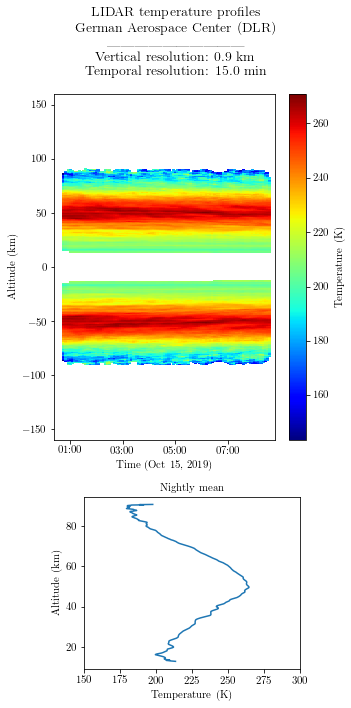

In [40]:
use_tex = 1 
if use_tex:
    ### Set tex font
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    # Set font size
    SMALL_SIZE = 10.95
    MEDIUM_SIZE = 10.95
    plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    ###

# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# plt.rcParams['font.family'] = "sans-serif"
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5,10), gridspec_kw={'height_ratios': [2, 1]})
im_temp = ax0.pcolormesh(DS.time.values, y_ticks, np.matrix.transpose(c_dist), cmap='jet')
# im_temp = ax0.pcolormesh(DS.time, DS.alt_plot, np.matrix.transpose(DS.tmp_perturbation.values),
#                          cmap='jet')#, vmin= -5, vmax = 5)
#ax0.set_ylim(20,90)

# Labels
cbar = fig.colorbar(im_temp, ax=ax0)
cbar.set_label('Temperature (K)')
ax0.set_xlabel('Time ({})'.format(datetime.datetime.strftime(date, '%b %d, %Y')))
ax0.set_ylabel('Altitude (km)')

# X-Ticks
# if day > daybefore show date in new line
h_fmt = mdates.DateFormatter('%H:%M')
h_interv = mdates.HourLocator(interval = 2)
ax0.xaxis.set_major_locator(h_interv)
ax0.xaxis.set_major_formatter(h_fmt)

#fig.autofmt_xdate()
#xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
#ax0.xaxis.set_major_formatter(xfmt)


# tempMean = np.where(tempMean == 0, np.nan, tempMean)

## Mean Plot (altitude vs. temperature)
ax1.plot(DS.temperature.mean(axis=0), DS.alt_plot)
ax1.set_xlim(150,300)
ax1.set_aspect('1.4')

# Labels 
ax1.set_title('Nightly mean')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (km)')

fig.suptitle('LIDAR temperature profiles\n \
German Aerospace Center (DLR) \n \
------------------------------ \n \
Vertical resolution: {} km\n \
Temporal resolution: {} min'.format(DS.altitude.resolution / 1000, DS.time.resolution / (1000*60)), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.88]) # tuple (left, bottom, right, top),

In [12]:
#### INFO ####
# XARRAY
# values
# dims
# coords
# attrs

# Latitude
# Longitude
# Height of station above WGS84
# time_offset (Seconds since reference date)
# referenceYear = 1970
# time 
    # units: milliseconds since time_offset
    # long_name: time tag of current profile
    # resolution: 1800000 for T30 1200000 for T20 3600000 for T60

# root = xr.Dataset(fileName, "r")
# with open(file..) as f
# with changes the context Seaborn library for plots
# with sns.axes_style("darkgrid")
# with for opening files and plotting with certain setting

In [13]:
# x = signal.lfilter(b,a,np.flip(DS.temperature.values, axis=1), axis=1))
# x = np.flip(DS.temperature.values, axis=1)
# print(DS.temperature.values[50,500], x[50,1599-500]) # check if flipped correctly for top to bottom butterworth filter

In [67]:
# Generate vector only of valid values
highcut = 1/20 # 20km critical wavelength
fs = 1/0.1 # 100m sample wavelength
b, a = butter_lowpass(highcut, fs, order=5)

print(b,a)

tmp = DS.temperature.dropna(dim='time', how="all")
tmp = tmp.dropna(dim='altitude', how="any")
tf = signal.lfilter(b,a,tmp.values, axis=1)
tmp['tmp_bg'] = (['time', 'altitude'], tf)
tmp['tmp_pert'] = tmp - tmp.tmp_bg
tmp.tmp_pert

0.01
[9.09286611e-10 4.54643306e-09 9.09286611e-09 9.09286611e-09
 4.54643306e-09 9.09286611e-10] [ 1.         -4.89833715  9.59849709 -9.40530799  4.60847636 -0.90332829]


<xarray.DataArray 'tmp_pert' (time: 95, altitude: 682)>
array([[201.61441 , 201.391737, 200.968998, ..., -52.414167, -50.284499,
        -48.796447],
       [203.647293, 203.387022, 202.971928, ..., -33.678202, -31.319823,
        -31.102238],
       [205.76561 , 205.493711, 205.084584, ..., -38.45469 , -36.360046,
        -35.224459],
       ...,
       [205.766159, 205.552412, 205.296391, ..., -24.282225, -22.523603,
        -21.552109],
       [205.373642, 205.184492, 204.965367, ..., -22.969258, -22.35377 ,
        -22.95958 ],
       [205.737137, 205.564619, 205.357151, ..., -22.515045, -22.659977,
        -24.061233]])
Coordinates:
  * time          (time) datetime64[ns] 2019-10-15T00:42:55 ... 2019-10-15T08:32:55
  * altitude      (altitude) uint32 15000 15100 15200 ... 82900 83000 83100
    timeCentered  (time) datetime64[ns] 2019-10-15T00:45:30 ... 2019-10-15T08:29:40
    tmp_bg        (time, altitude) float64 1.833e-07 1.998e-06 ... 209.1 208.8
    tmp_pert      (time, altitu

/Users/tennismichel/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


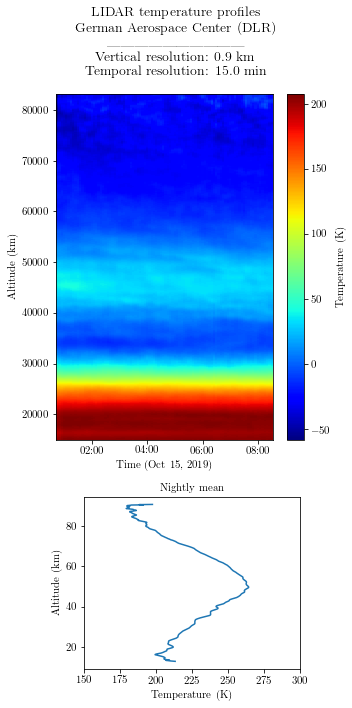

In [68]:
use_tex = 1 
if use_tex:
    ### Set tex font
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    # Set font size
    SMALL_SIZE = 10.95
    MEDIUM_SIZE = 10.95
    plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    ###

# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# plt.rcParams['font.family'] = "sans-serif"
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5,10), gridspec_kw={'height_ratios': [2, 1]})
im_temp = ax0.pcolormesh(tmp.time.values, tmp.altitude.values, np.matrix.transpose(tmp.tmp_pert.values), cmap='jet')
# im_temp = ax0.pcolormesh(DS.time, DS.alt_plot, np.matrix.transpose(DS.tmp_perturbation.values),
#                          cmap='jet')#, vmin= -5, vmax = 5)
#ax0.set_ylim(20,90)

# Labels
cbar = fig.colorbar(im_temp, ax=ax0)
cbar.set_label('Temperature (K)')
ax0.set_xlabel('Time ({})'.format(datetime.datetime.strftime(date, '%b %d, %Y')))
ax0.set_ylabel('Altitude (km)')

# X-Ticks
# if day > daybefore show date in new line
h_fmt = mdates.DateFormatter('%H:%M')
h_interv = mdates.HourLocator(interval = 2)
ax0.xaxis.set_major_locator(h_interv)
ax0.xaxis.set_major_formatter(h_fmt)

#fig.autofmt_xdate()
#xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
#ax0.xaxis.set_major_formatter(xfmt)


# tempMean = np.where(tempMean == 0, np.nan, tempMean)

## Mean Plot (altitude vs. temperature)
ax1.plot(DS.temperature.mean(axis=0), DS.alt_plot)
ax1.set_xlim(150,300)
ax1.set_aspect('1.4')

# Labels 
ax1.set_title('Nightly mean')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (km)')

fig.suptitle('LIDAR temperature profiles\n \
German Aerospace Center (DLR) \n \
------------------------------ \n \
Vertical resolution: {} km\n \
Temporal resolution: {} min'.format(DS.altitude.resolution / 1000, DS.time.resolution / (1000*60)), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.88]) # tuple (left, bottom, right, top),